In [1]:
import json
import numpy as np
import random
import sys
from tqdm import tqdm
import re
from pathlib import Path

import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer

from wikidataintegrator import wdi_core
from wikidata.client import Client
import wikidata
import en_core_web_sm
nlp = en_core_web_sm.load()

from IPython.display import clear_output
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
%matplotlib inline

#############################################################
from utils import get_triplets_by_idd, get_description_name
from datasets import load_rubq, load_simple_questions, combined_dataset
from models import EncoderBERT, get_projection_module_simple, get_tokenizer
from reject import reject_by_metric
from train import train_ensemble
from eval_models import eval_ensemble
from get_props import presearch_sq, presearch_rubq

%load_ext autoreload
%autoreload 1

2022-08-16 15:04:19.219160: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-16 15:04:19.223713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-08-16 15:04:19.223740: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(m

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Loading Graph Embeddings and Questions

In [3]:
#path to full list of embeddings and full list of ids (one2one correspondence with embeddings)
PATH_TO_EMBEDDINGS_Q = "../new_data/entitie_embeddings_ru.json" 
PATH_TO_IDS = "../new_data/entitie_ids_ru_filtered.json"
PATH_TO_EMBEDDINGS_P = "../new_data/entitie_P_embeddings_ru.json" 

graph_embeddings_Q = json.load(open(PATH_TO_EMBEDDINGS_Q))
graph_embeddings_P = json.load(open(PATH_TO_EMBEDDINGS_P))

In [4]:
%autoreload

MASTER_SEED = 42

questions_train, relations_train, entities_train, answers_train, questions_val, relations_val, entities_val, answers_val, questions_test, answers_test = load_rubq(MASTER_SEED, graph_embeddings_Q, graph_embeddings_P)
simple_questions_train, simple_questions_val = load_simple_questions(MASTER_SEED, graph_embeddings_Q, graph_embeddings_P)

/notebook/meker/KBQA/datasets.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  answers_train = np.array(answers)[train_ids]
/notebook/meker/KBQA/datasets.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  answers_val = np.array(answers)[val_ids]


308
296
1186
16414


100% 16414/16414 [00:00<00:00, 212216.97it/s]

8327


### Dataset and Dataloaders

In [5]:
%autoreload

train_dataset = combined_dataset(questions_train, answers_train, entities_train, relations_train, graph_embeddings_Q, graph_embeddings_P, simple_questions_train, device)
val_dataset = combined_dataset(questions_val, answers_val, entities_val, relations_val, graph_embeddings_Q, graph_embeddings_P, simple_questions_val, device)

val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=64, shuffle=False)

In [6]:
embeddings_Q = graph_embeddings_Q
ids_list = list(graph_embeddings_Q.keys())
embeddings_Q = [embeddings_Q[Q] for Q in ids_list]
embeddings_tensor_Q = torch.FloatTensor(embeddings_Q)

embeddings_P = graph_embeddings_P
embeddings_P = [embeddings_P[P] for P in graph_embeddings_P.keys()]
embeddings_tensor_P = torch.FloatTensor(embeddings_P)

candidates = list(np.load("./data/presearched_fixed_rubq_test.npy", allow_pickle=True))

### Training loop

In [7]:
loss = nn.MSELoss()
loss_name = str(loss)[:-2]
proj_hidden_size = 512

models_path = Path(f'./models/{loss_name}_{proj_hidden_size}_full_stochastic_rubq/')
models_path.mkdir(parents=True, exist_ok=True)

N_EPOCHS = 30
N_MODELS = 15

sq_val_cands = np.load('data/presearched_fixed_sq_val.npy', allow_pickle=True)
rubq_val_cands = np.load('data/presearched_fixed_rubq_val.npy', allow_pickle=True)
val_cands = list(rubq_val_cands) + list(sq_val_cands)

questions_val = list(questions_val)
answers_val = list(answers_val)

for e, p, a, q in tqdm(simple_questions_val):
    questions_val.append(q)
    answers_val.append([a])
    
questions_val = np.array(questions_val)
answers_val = np.array(answers_val)

100% 1000/1000 [00:00<00:00, 222038.33it/s]
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [8]:
%autoreload

train_ensemble(N_MODELS, N_EPOCHS, proj_hidden_size, train_dataset, val_dataloader, models_path, device, loss, val_cands, questions_val, answers_val, graph_embeddings_P, graph_embeddings_Q)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examp

Accuracy:  0.425
EPOCH 1  train loss  0.3127306304101286  val loss  0.26170208863914013  val acc  0.425
New loss checkpoint achieved: previous inf new 0.26170208863914013
New acc checkpoint achieved: previous 0.0 new 0.425


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.70it/s]


Accuracy:  0.47307692307692306
EPOCH 2  train loss  0.24203959145936474  val loss  0.23970969207584858  val acc  0.47307692307692306
New loss checkpoint achieved: previous 0.26170208863914013 new 0.23970969207584858
New acc checkpoint achieved: previous 0.425 new 0.47307692307692306


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.86it/s]


Accuracy:  0.4932692307692308
EPOCH 3  train loss  0.21850538870383954  val loss  0.2309162775054574  val acc  0.4932692307692308
New loss checkpoint achieved: previous 0.23970969207584858 new 0.2309162775054574
New acc checkpoint achieved: previous 0.47307692307692306 new 0.4932692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.19it/s]


Accuracy:  0.4971153846153846
EPOCH 4  train loss  0.2011688245010787  val loss  0.22689878288656473  val acc  0.4971153846153846
New loss checkpoint achieved: previous 0.2309162775054574 new 0.22689878288656473
New acc checkpoint achieved: previous 0.4932692307692308 new 0.4971153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.27it/s]


Accuracy:  0.5038461538461538
EPOCH 5  train loss  0.18992566856844673  val loss  0.22636163048446178  val acc  0.5038461538461538
New loss checkpoint achieved: previous 0.22689878288656473 new 0.22636163048446178
New acc checkpoint achieved: previous 0.4971153846153846 new 0.5038461538461538


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 86.09it/s]


Accuracy:  0.5057692307692307
EPOCH 6  train loss  0.1798028077544837  val loss  0.22359620407223701  val acc  0.5057692307692307
New loss checkpoint achieved: previous 0.22636163048446178 new 0.22359620407223701
New acc checkpoint achieved: previous 0.5038461538461538 new 0.5057692307692307


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 76.76it/s]


Accuracy:  0.510576923076923
EPOCH 7  train loss  0.16881662350276422  val loss  0.22127043176442385  val acc  0.510576923076923
New loss checkpoint achieved: previous 0.22359620407223701 new 0.22127043176442385
New acc checkpoint achieved: previous 0.5057692307692307 new 0.510576923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.27it/s]


Accuracy:  0.5163461538461539
EPOCH 8  train loss  0.15833186268292623  val loss  0.22302817180752754  val acc  0.5163461538461539
New acc checkpoint achieved: previous 0.510576923076923 new 0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.59it/s]


Accuracy:  0.5230769230769231
EPOCH 9  train loss  0.14987605084376088  val loss  0.2255006218329072  val acc  0.5230769230769231
New acc checkpoint achieved: previous 0.5163461538461539 new 0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.64it/s]


Accuracy:  0.510576923076923
EPOCH 10  train loss  0.14223471624327116  val loss  0.22321512084454298  val acc  0.510576923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.98it/s]


Accuracy:  0.525
EPOCH 11  train loss  0.13529217307423724  val loss  0.22749011125415564  val acc  0.525
New acc checkpoint achieved: previous 0.5230769230769231 new 0.525


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.67it/s]


Accuracy:  0.5173076923076924
EPOCH 12  train loss  0.12838078470065675  val loss  0.22585769835859537  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.19it/s]


Accuracy:  0.5134615384615384
EPOCH 13  train loss  0.1240515466137179  val loss  0.2383957849815488  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.51it/s]


Accuracy:  0.5163461538461539
EPOCH 14  train loss  0.11877773271809364  val loss  0.23732701130211353  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.37it/s]


Accuracy:  0.5153846153846153
EPOCH 15  train loss  0.11371786963066151  val loss  0.23519343603402376  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.10it/s]


Accuracy:  0.5182692307692308
EPOCH 16  train loss  0.1096030449302032  val loss  0.23997862916439772  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 73.41it/s]


Accuracy:  0.5163461538461539
EPOCH 17  train loss  0.10363459066841109  val loss  0.2427899306640029  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.84it/s]


Accuracy:  0.5144230769230769
EPOCH 18  train loss  0.09921639631020612  val loss  0.24517500307410955  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.58it/s]


Accuracy:  0.5221153846153846
EPOCH 19  train loss  0.0956428492249086  val loss  0.23969347588717937  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.69it/s]


Accuracy:  0.5153846153846153
EPOCH 20  train loss  0.08931400408518725  val loss  0.24626608099788427  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.48it/s]


Accuracy:  0.5153846153846153
EPOCH 21  train loss  0.08476278462029736  val loss  0.24461111798882484  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.91it/s]


Accuracy:  0.5221153846153846
EPOCH 22  train loss  0.08107960917826357  val loss  0.2492188299074769  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.96it/s]


Accuracy:  0.5211538461538462
EPOCH 23  train loss  0.07758040835374388  val loss  0.25435515586286783  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.18it/s]


Accuracy:  0.5201923076923077
EPOCH 24  train loss  0.07462794584190023  val loss  0.2539083482697606  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.62it/s]


Accuracy:  0.5201923076923077
EPOCH 25  train loss  0.07085696318796997  val loss  0.2606330504640937  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.43it/s]


Accuracy:  0.5240384615384616
EPOCH 26  train loss  0.06827553107949166  val loss  0.2555622486397624  val acc  0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 76.69it/s]


Accuracy:  0.5201923076923077
EPOCH 27  train loss  0.06536084442431557  val loss  0.2645247094333172  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.83it/s]


Accuracy:  0.5298076923076923
EPOCH 28  train loss  0.062123566833806446  val loss  0.2630989346653223  val acc  0.5298076923076923
New acc checkpoint achieved: previous 0.525 new 0.5298076923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.49it/s]


Accuracy:  0.5230769230769231
EPOCH 29  train loss  0.05966693602887721  val loss  0.26039189100265503  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.10it/s]


Accuracy:  0.5173076923076924
EPOCH 30  train loss  0.05796357777355046  val loss  0.2671871893107891  val acc  0.5173076923076924


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.4201923076923077
EPOCH 1  train loss  0.3185778899953283  val loss  0.2621742766350508  val acc  0.4201923076923077
New loss checkpoint achieved: previous inf new 0.2621742766350508
New acc checkpoint achieved: previous 0.0 new 0.4201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.67it/s]


Accuracy:  0.4826923076923077
EPOCH 2  train loss  0.23819911916708125  val loss  0.2368626995012164  val acc  0.4826923076923077
New loss checkpoint achieved: previous 0.2621742766350508 new 0.2368626995012164
New acc checkpoint achieved: previous 0.4201923076923077 new 0.4826923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.01it/s]


Accuracy:  0.4951923076923077
EPOCH 3  train loss  0.21386340466038933  val loss  0.23142104502767324  val acc  0.4951923076923077
New loss checkpoint achieved: previous 0.2368626995012164 new 0.23142104502767324
New acc checkpoint achieved: previous 0.4826923076923077 new 0.4951923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.90it/s]


Accuracy:  0.5028846153846154
EPOCH 4  train loss  0.19667335779502473  val loss  0.2246059663593769  val acc  0.5028846153846154
New loss checkpoint achieved: previous 0.23142104502767324 new 0.2246059663593769
New acc checkpoint achieved: previous 0.4951923076923077 new 0.5028846153846154


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.93it/s]


Accuracy:  0.49903846153846154
EPOCH 5  train loss  0.182678473149908  val loss  0.2250878857448697  val acc  0.49903846153846154


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 75.10it/s]


Accuracy:  0.510576923076923
EPOCH 6  train loss  0.17121033807253017  val loss  0.22631392627954483  val acc  0.510576923076923
New acc checkpoint achieved: previous 0.5028846153846154 new 0.510576923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 76.04it/s]


Accuracy:  0.525
EPOCH 7  train loss  0.16125866937740096  val loss  0.2242582319304347  val acc  0.525
New loss checkpoint achieved: previous 0.2246059663593769 new 0.2242582319304347
New acc checkpoint achieved: previous 0.510576923076923 new 0.525


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 73.34it/s]


Accuracy:  0.5221153846153846
EPOCH 8  train loss  0.15172850167186097  val loss  0.22013716958463192  val acc  0.5221153846153846
New loss checkpoint achieved: previous 0.2242582319304347 new 0.22013716958463192


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.72it/s]


Accuracy:  0.5115384615384615
EPOCH 9  train loss  0.14360704754704032  val loss  0.22450163215398788  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.25it/s]


Accuracy:  0.5221153846153846
EPOCH 10  train loss  0.13765378219300303  val loss  0.22921034321188927  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.55it/s]


Accuracy:  0.5153846153846153
EPOCH 11  train loss  0.1306754930009102  val loss  0.22767668310552835  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.20it/s]


Accuracy:  0.5182692307692308
EPOCH 12  train loss  0.1273339675932095  val loss  0.22865366376936436  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 73.53it/s]


Accuracy:  0.5134615384615384
EPOCH 13  train loss  0.12119863188729205  val loss  0.23352606408298016  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.42it/s]


Accuracy:  0.5163461538461539
EPOCH 14  train loss  0.11454241999007504  val loss  0.2356887450441718  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.77it/s]


Accuracy:  0.5221153846153846
EPOCH 15  train loss  0.10803337851218109  val loss  0.23491726256906986  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.77it/s]


Accuracy:  0.525
EPOCH 16  train loss  0.10259720156418867  val loss  0.23013311997056007  val acc  0.525


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.58it/s]


Accuracy:  0.5201923076923077
EPOCH 17  train loss  0.09829447534063766  val loss  0.24161278177052736  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 86.08it/s]


Accuracy:  0.5230769230769231
EPOCH 18  train loss  0.09342725607084817  val loss  0.23925169371068478  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.73it/s]


Accuracy:  0.5269230769230769
EPOCH 19  train loss  0.08954521255760357  val loss  0.24110864102840424  val acc  0.5269230769230769
New acc checkpoint achieved: previous 0.525 new 0.5269230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 77.53it/s]


Accuracy:  0.5269230769230769
EPOCH 20  train loss  0.08545978457249444  val loss  0.24502745550125837  val acc  0.5269230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.34it/s]


Accuracy:  0.5230769230769231
EPOCH 21  train loss  0.08136917490126758  val loss  0.25023852102458477  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.99it/s]


Accuracy:  0.5144230769230769
EPOCH 22  train loss  0.07805969951481655  val loss  0.2502396507188678  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.53it/s]


Accuracy:  0.5221153846153846
EPOCH 23  train loss  0.0749349042387872  val loss  0.25271432381123304  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.63it/s]


Accuracy:  0.5201923076923077
EPOCH 24  train loss  0.0714725683089988  val loss  0.25703386776149273  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.34it/s]


Accuracy:  0.5201923076923077
EPOCH 25  train loss  0.06822910034579449  val loss  0.25427341740578413  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.50it/s]


Accuracy:  0.5211538461538462
EPOCH 26  train loss  0.06529767592919283  val loss  0.261907571926713  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.57it/s]


Accuracy:  0.5230769230769231
EPOCH 27  train loss  0.06300457624782776  val loss  0.25656211003661156  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.98it/s]


Accuracy:  0.5173076923076924
EPOCH 28  train loss  0.05961164912401602  val loss  0.2603166429325938  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 77.45it/s]


Accuracy:  0.5221153846153846
EPOCH 29  train loss  0.0571264516369536  val loss  0.2643472095951438  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.35it/s]


Accuracy:  0.5173076923076924
EPOCH 30  train loss  0.05490075090322001  val loss  0.2639444703236222  val acc  0.5173076923076924


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.40192307692307694
EPOCH 1  train loss  0.31856255014908724  val loss  0.2677881717681885  val acc  0.40192307692307694
New loss checkpoint achieved: previous inf new 0.2677881717681885
New acc checkpoint achieved: previous 0.0 new 0.40192307692307694


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.61it/s]


Accuracy:  0.4567307692307692
EPOCH 2  train loss  0.24364434401022977  val loss  0.24366656970232725  val acc  0.4567307692307692
New loss checkpoint achieved: previous 0.2677881717681885 new 0.24366656970232725
New acc checkpoint achieved: previous 0.40192307692307694 new 0.4567307692307692


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.99it/s]


Accuracy:  0.4971153846153846
EPOCH 3  train loss  0.22215986097681112  val loss  0.23661861661821604  val acc  0.4971153846153846
New loss checkpoint achieved: previous 0.24366656970232725 new 0.23661861661821604
New acc checkpoint achieved: previous 0.4567307692307692 new 0.4971153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.41it/s]


Accuracy:  0.510576923076923
EPOCH 4  train loss  0.2058192259021874  val loss  0.22583515662699938  val acc  0.510576923076923
New loss checkpoint achieved: previous 0.23661861661821604 new 0.22583515662699938
New acc checkpoint achieved: previous 0.4971153846153846 new 0.510576923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.26it/s]


Accuracy:  0.5096153846153846
EPOCH 5  train loss  0.1941126972950738  val loss  0.22618846129626036  val acc  0.5096153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.39it/s]


Accuracy:  0.5134615384615384
EPOCH 6  train loss  0.18239313415412245  val loss  0.22697092592716217  val acc  0.5134615384615384
New acc checkpoint achieved: previous 0.510576923076923 new 0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.34it/s]


Accuracy:  0.5182692307692308
EPOCH 7  train loss  0.17350051295140695  val loss  0.22733313962817192  val acc  0.5182692307692308
New acc checkpoint achieved: previous 0.5134615384615384 new 0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.35it/s]


Accuracy:  0.5125
EPOCH 8  train loss  0.16467109553772827  val loss  0.22481086198240519  val acc  0.5125
New loss checkpoint achieved: previous 0.22583515662699938 new 0.22481086198240519


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.94it/s]


Accuracy:  0.5201923076923077
EPOCH 9  train loss  0.1555913568570696  val loss  0.2246673759073019  val acc  0.5201923076923077
New loss checkpoint achieved: previous 0.22481086198240519 new 0.2246673759073019
New acc checkpoint achieved: previous 0.5182692307692308 new 0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.90it/s]


Accuracy:  0.5269230769230769
EPOCH 10  train loss  0.14823142721735197  val loss  0.22472704760730267  val acc  0.5269230769230769
New acc checkpoint achieved: previous 0.5201923076923077 new 0.5269230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.01it/s]


Accuracy:  0.5144230769230769
EPOCH 11  train loss  0.14319578005835928  val loss  0.23245536535978317  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.73it/s]


Accuracy:  0.5115384615384615
EPOCH 12  train loss  0.13577844754889093  val loss  0.23548924084752798  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.59it/s]


Accuracy:  0.5269230769230769
EPOCH 13  train loss  0.12972014872678395  val loss  0.23233009036630392  val acc  0.5269230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.16it/s]


Accuracy:  0.5192307692307693
EPOCH 14  train loss  0.12480797560821319  val loss  0.24310192558914423  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.77it/s]


Accuracy:  0.5163461538461539
EPOCH 15  train loss  0.1212159255840655  val loss  0.240921001881361  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.42it/s]


Accuracy:  0.5115384615384615
EPOCH 16  train loss  0.11518912338491144  val loss  0.23933241423219442  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.75it/s]


Accuracy:  0.5201923076923077
EPOCH 17  train loss  0.11105294943112752  val loss  0.23237015772610903  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.83it/s]


Accuracy:  0.5096153846153846
EPOCH 18  train loss  0.10631325693222983  val loss  0.24007307831197977  val acc  0.5096153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.45it/s]


Accuracy:  0.5067307692307692
EPOCH 19  train loss  0.10342968158937733  val loss  0.2433172482997179  val acc  0.5067307692307692


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.26it/s]


Accuracy:  0.5115384615384615
EPOCH 20  train loss  0.10019390689658708  val loss  0.24277427792549133  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.53it/s]


Accuracy:  0.5057692307692307
EPOCH 21  train loss  0.09566104643303773  val loss  0.24884457513689995  val acc  0.5057692307692307


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.22it/s]


Accuracy:  0.5115384615384615
EPOCH 22  train loss  0.09099647595450797  val loss  0.24915824923664331  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.42it/s]


Accuracy:  0.5144230769230769
EPOCH 23  train loss  0.0878348090396873  val loss  0.2493922244757414  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 74.99it/s]


Accuracy:  0.510576923076923
EPOCH 24  train loss  0.0844776860984235  val loss  0.25496672187000513  val acc  0.510576923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.65it/s]


Accuracy:  0.5115384615384615
EPOCH 25  train loss  0.08042904040936766  val loss  0.2587739257141948  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.06it/s]


Accuracy:  0.5153846153846153
EPOCH 26  train loss  0.07714802322202716  val loss  0.25859474670141935  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.36it/s]


Accuracy:  0.5192307692307693
EPOCH 27  train loss  0.07411305824744291  val loss  0.2613206710666418  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.28it/s]


Accuracy:  0.525
EPOCH 28  train loss  0.07164098489387281  val loss  0.2596329590305686  val acc  0.525


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.03it/s]


Accuracy:  0.5230769230769231
EPOCH 29  train loss  0.06929296679024038  val loss  0.2606350500136614  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.24it/s]


Accuracy:  0.5173076923076924
EPOCH 30  train loss  0.06705214237344675  val loss  0.2645408697426319  val acc  0.5173076923076924


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.38653846153846155
EPOCH 1  train loss  0.33440470438579034  val loss  0.2796191144734621  val acc  0.38653846153846155
New loss checkpoint achieved: previous inf new 0.2796191144734621
New acc checkpoint achieved: previous 0.0 new 0.38653846153846155


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.62it/s]


Accuracy:  0.46442307692307694
EPOCH 2  train loss  0.2525406872917866  val loss  0.24716903641819954  val acc  0.46442307692307694
New loss checkpoint achieved: previous 0.2796191144734621 new 0.24716903641819954
New acc checkpoint achieved: previous 0.38653846153846155 new 0.46442307692307694


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.54it/s]


Accuracy:  0.4807692307692308
EPOCH 3  train loss  0.22648542361526652  val loss  0.23658232297748327  val acc  0.4807692307692308
New loss checkpoint achieved: previous 0.24716903641819954 new 0.23658232297748327
New acc checkpoint achieved: previous 0.46442307692307694 new 0.4807692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.46it/s]


Accuracy:  0.49230769230769234
EPOCH 4  train loss  0.20988762031855254  val loss  0.23128911387175322  val acc  0.49230769230769234
New loss checkpoint achieved: previous 0.23658232297748327 new 0.23128911387175322
New acc checkpoint achieved: previous 0.4807692307692308 new 0.49230769230769234


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.74it/s]


Accuracy:  0.49903846153846154
EPOCH 5  train loss  0.19968499140492801  val loss  0.22951581422239542  val acc  0.49903846153846154
New loss checkpoint achieved: previous 0.23128911387175322 new 0.22951581422239542
New acc checkpoint achieved: previous 0.49230769230769234 new 0.49903846153846154


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.00it/s]


Accuracy:  0.5038461538461538
EPOCH 6  train loss  0.1858639808307434  val loss  0.22688711434602737  val acc  0.5038461538461538
New loss checkpoint achieved: previous 0.22951581422239542 new 0.22688711434602737
New acc checkpoint achieved: previous 0.49903846153846154 new 0.5038461538461538


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.85it/s]


Accuracy:  0.5076923076923077
EPOCH 7  train loss  0.17524411644915056  val loss  0.22124789096415043  val acc  0.5076923076923077
New loss checkpoint achieved: previous 0.22688711434602737 new 0.22124789096415043
New acc checkpoint achieved: previous 0.5038461538461538 new 0.5076923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.81it/s]


Accuracy:  0.5086538461538461
EPOCH 8  train loss  0.1665041215460876  val loss  0.22435356955975294  val acc  0.5086538461538461
New acc checkpoint achieved: previous 0.5076923076923077 new 0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 75.57it/s]


Accuracy:  0.5134615384615384
EPOCH 9  train loss  0.15881737193156933  val loss  0.22452926449477673  val acc  0.5134615384615384
New acc checkpoint achieved: previous 0.5086538461538461 new 0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.52it/s]


Accuracy:  0.5153846153846153
EPOCH 10  train loss  0.15068302509085885  val loss  0.22854836285114288  val acc  0.5153846153846153
New acc checkpoint achieved: previous 0.5134615384615384 new 0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 74.36it/s]


Accuracy:  0.5134615384615384
EPOCH 11  train loss  0.1436804331967543  val loss  0.22826087567955256  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.84it/s]


Accuracy:  0.5192307692307693
EPOCH 12  train loss  0.1368601186008289  val loss  0.22853525169193745  val acc  0.5192307692307693
New acc checkpoint achieved: previous 0.5153846153846153 new 0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.77it/s]


Accuracy:  0.5086538461538461
EPOCH 13  train loss  0.13104414869228315  val loss  0.2322545489296317  val acc  0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.26it/s]


Accuracy:  0.5096153846153846
EPOCH 14  train loss  0.1262871888947898  val loss  0.2365717003121972  val acc  0.5096153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.05it/s]


Accuracy:  0.5192307692307693
EPOCH 15  train loss  0.12206513074965313  val loss  0.23417413607239723  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 76.35it/s]


Accuracy:  0.5115384615384615
EPOCH 16  train loss  0.11591189457424755  val loss  0.23391404561698437  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.83it/s]


Accuracy:  0.5096153846153846
EPOCH 17  train loss  0.10969944516646452  val loss  0.2386470614001155  val acc  0.5096153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.42it/s]


Accuracy:  0.5134615384615384
EPOCH 18  train loss  0.1043422539429418  val loss  0.23567173071205616  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.52it/s]


Accuracy:  0.510576923076923
EPOCH 19  train loss  0.10159483205141692  val loss  0.2362545235082507  val acc  0.510576923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.12it/s]


Accuracy:  0.5192307692307693
EPOCH 20  train loss  0.0966125133222547  val loss  0.24543598759919405  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.98it/s]


Accuracy:  0.5240384615384616
EPOCH 21  train loss  0.09345539627147131  val loss  0.24663044046610594  val acc  0.5240384615384616
New acc checkpoint achieved: previous 0.5192307692307693 new 0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.89it/s]


Accuracy:  0.5134615384615384
EPOCH 22  train loss  0.08952859885476787  val loss  0.25176595337688923  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.47it/s]


Accuracy:  0.5096153846153846
EPOCH 23  train loss  0.08407964229840657  val loss  0.256230934523046  val acc  0.5096153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.25it/s]


Accuracy:  0.5173076923076924
EPOCH 24  train loss  0.08004371256663881  val loss  0.25330499932169914  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 74.62it/s]


Accuracy:  0.5211538461538462
EPOCH 25  train loss  0.0757718752941181  val loss  0.2513429457321763  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.05it/s]


Accuracy:  0.5153846153846153
EPOCH 26  train loss  0.07191064353261528  val loss  0.2554891016334295  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.45it/s]


Accuracy:  0.5192307692307693
EPOCH 27  train loss  0.06923497683400738  val loss  0.25895722955465317  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.68it/s]


Accuracy:  0.5221153846153846
EPOCH 28  train loss  0.06597366386318002  val loss  0.26025151554495096  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.45it/s]


Accuracy:  0.5134615384615384
EPOCH 29  train loss  0.06386869577369814  val loss  0.259812593460083  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.70it/s]


Accuracy:  0.5182692307692308
EPOCH 30  train loss  0.06164864412155645  val loss  0.26089241448789835  val acc  0.5182692307692308


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.41346153846153844
EPOCH 1  train loss  0.32869542981016225  val loss  0.26918656658381224  val acc  0.41346153846153844
New loss checkpoint achieved: previous inf new 0.26918656658381224
New acc checkpoint achieved: previous 0.0 new 0.41346153846153844


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.86it/s]


Accuracy:  0.47692307692307695
EPOCH 2  train loss  0.24423248153822175  val loss  0.24047825019806623  val acc  0.47692307692307695
New loss checkpoint achieved: previous 0.26918656658381224 new 0.24047825019806623
New acc checkpoint achieved: previous 0.41346153846153844 new 0.47692307692307695


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.28it/s]


Accuracy:  0.5019230769230769
EPOCH 3  train loss  0.2183218233544251  val loss  0.22949360869824886  val acc  0.5019230769230769
New loss checkpoint achieved: previous 0.24047825019806623 new 0.22949360869824886
New acc checkpoint achieved: previous 0.47692307692307695 new 0.5019230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.61it/s]


Accuracy:  0.5076923076923077
EPOCH 4  train loss  0.20075451107374553  val loss  0.22792056668549776  val acc  0.5076923076923077
New loss checkpoint achieved: previous 0.22949360869824886 new 0.22792056668549776
New acc checkpoint achieved: previous 0.5019230769230769 new 0.5076923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.14it/s]


Accuracy:  0.5144230769230769
EPOCH 5  train loss  0.1860382373219934  val loss  0.22031934652477503  val acc  0.5144230769230769
New loss checkpoint achieved: previous 0.22792056668549776 new 0.22031934652477503
New acc checkpoint achieved: previous 0.5076923076923077 new 0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.01it/s]


Accuracy:  0.5115384615384615
EPOCH 6  train loss  0.17350076318814836  val loss  0.22215797379612923  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.05it/s]


Accuracy:  0.5134615384615384
EPOCH 7  train loss  0.16298299873697347  val loss  0.22093066666275263  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.75it/s]


Accuracy:  0.5201923076923077
EPOCH 8  train loss  0.1540800741520421  val loss  0.22113962098956108  val acc  0.5201923076923077
New acc checkpoint achieved: previous 0.5144230769230769 new 0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.15it/s]


Accuracy:  0.5182692307692308
EPOCH 9  train loss  0.14586538493890186  val loss  0.2206081347540021  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.64it/s]


Accuracy:  0.5163461538461539
EPOCH 10  train loss  0.13847795905994958  val loss  0.2277862001210451  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.13it/s]


Accuracy:  0.525
EPOCH 11  train loss  0.13118101155449605  val loss  0.2279954617843032  val acc  0.525
New acc checkpoint achieved: previous 0.5201923076923077 new 0.525


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.45it/s]


Accuracy:  0.5182692307692308
EPOCH 12  train loss  0.12508537915760073  val loss  0.22317691333591938  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.65it/s]


Accuracy:  0.5144230769230769
EPOCH 13  train loss  0.12035564769958627  val loss  0.2321969661861658  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.98it/s]


Accuracy:  0.5153846153846153
EPOCH 14  train loss  0.1134954019096391  val loss  0.23443607613444328  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.16it/s]


Accuracy:  0.5221153846153846
EPOCH 15  train loss  0.10788831898364527  val loss  0.23535547219216824  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.16it/s]


Accuracy:  0.5144230769230769
EPOCH 16  train loss  0.10243132183777875  val loss  0.2372042192146182  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.68it/s]


Accuracy:  0.5240384615384616
EPOCH 17  train loss  0.09765820436436555  val loss  0.23902221582829952  val acc  0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.65it/s]


Accuracy:  0.5259615384615385
EPOCH 18  train loss  0.092457701034587  val loss  0.24286885559558868  val acc  0.5259615384615385
New acc checkpoint achieved: previous 0.525 new 0.5259615384615385


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 77.74it/s]


Accuracy:  0.5221153846153846
EPOCH 19  train loss  0.08759919155774445  val loss  0.24206726718693972  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.30it/s]


Accuracy:  0.5298076923076923
EPOCH 20  train loss  0.08318620515537672  val loss  0.24432139284908772  val acc  0.5298076923076923
New acc checkpoint achieved: previous 0.5259615384615385 new 0.5298076923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 72.88it/s]


Accuracy:  0.5192307692307693
EPOCH 21  train loss  0.07920391966813597  val loss  0.24314922839403152  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.86it/s]


Accuracy:  0.5182692307692308
EPOCH 22  train loss  0.07567323615838742  val loss  0.25053946767002344  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.26it/s]


Accuracy:  0.5192307692307693
EPOCH 23  train loss  0.07138550981622317  val loss  0.2520694937556982  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.52it/s]


Accuracy:  0.5221153846153846
EPOCH 24  train loss  0.06874231480318925  val loss  0.2541657406836748  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.14it/s]


Accuracy:  0.5211538461538462
EPOCH 25  train loss  0.06571395582808502  val loss  0.2579742921516299  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 72.49it/s]


Accuracy:  0.5192307692307693
EPOCH 26  train loss  0.06269140503016012  val loss  0.2604966489598155  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.03it/s]


Accuracy:  0.5192307692307693
EPOCH 27  train loss  0.05956303501694367  val loss  0.26119915302842855  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.52it/s]


Accuracy:  0.5230769230769231
EPOCH 28  train loss  0.057148310420071256  val loss  0.2606784664094448  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.71it/s]


Accuracy:  0.5192307692307693
EPOCH 29  train loss  0.054825146040269016  val loss  0.2627406483516097  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.44it/s]


Accuracy:  0.525
EPOCH 30  train loss  0.05235016021620611  val loss  0.2627417165786028  val acc  0.525


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.42980769230769234
EPOCH 1  train loss  0.31303013899716836  val loss  0.26296828500926495  val acc  0.42980769230769234
New loss checkpoint achieved: previous inf new 0.26296828500926495
New acc checkpoint achieved: previous 0.0 new 0.42980769230769234


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 77.26it/s]


Accuracy:  0.47692307692307695
EPOCH 2  train loss  0.24151832032306442  val loss  0.24175188690423965  val acc  0.47692307692307695
New loss checkpoint achieved: previous 0.26296828500926495 new 0.24175188690423965
New acc checkpoint achieved: previous 0.42980769230769234 new 0.47692307692307695


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.82it/s]


Accuracy:  0.4913461538461538
EPOCH 3  train loss  0.2175092500602377  val loss  0.2358212610706687  val acc  0.4913461538461538
New loss checkpoint achieved: previous 0.24175188690423965 new 0.2358212610706687
New acc checkpoint achieved: previous 0.47692307692307695 new 0.4913461538461538


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.72it/s]


Accuracy:  0.5038461538461538
EPOCH 4  train loss  0.20243216305971146  val loss  0.2272040592506528  val acc  0.5038461538461538
New loss checkpoint achieved: previous 0.2358212610706687 new 0.2272040592506528
New acc checkpoint achieved: previous 0.4913461538461538 new 0.5038461538461538


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.23it/s]


Accuracy:  0.5076923076923077
EPOCH 5  train loss  0.19036528892044363  val loss  0.22670972906053066  val acc  0.5076923076923077
New loss checkpoint achieved: previous 0.2272040592506528 new 0.22670972906053066
New acc checkpoint achieved: previous 0.5038461538461538 new 0.5076923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 86.03it/s]


Accuracy:  0.5163461538461539
EPOCH 6  train loss  0.17873213787017198  val loss  0.22423761803656816  val acc  0.5163461538461539
New loss checkpoint achieved: previous 0.22670972906053066 new 0.22423761803656816
New acc checkpoint achieved: previous 0.5076923076923077 new 0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.38it/s]


Accuracy:  0.5125
EPOCH 7  train loss  0.1696457963051467  val loss  0.22481466736644506  val acc  0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.41it/s]


Accuracy:  0.5115384615384615
EPOCH 8  train loss  0.1617988413520928  val loss  0.227342015132308  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.81it/s]


Accuracy:  0.5076923076923077
EPOCH 9  train loss  0.15471976751397395  val loss  0.22569444868713617  val acc  0.5076923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.34it/s]


Accuracy:  0.5144230769230769
EPOCH 10  train loss  0.14760796892745742  val loss  0.22732178680598736  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.93it/s]


Accuracy:  0.5163461538461539
EPOCH 11  train loss  0.14072599551030274  val loss  0.23202953673899174  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.29it/s]


Accuracy:  0.5115384615384615
EPOCH 12  train loss  0.13541423465157376  val loss  0.2321900324895978  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.95it/s]


Accuracy:  0.5192307692307693
EPOCH 13  train loss  0.12977170263384952  val loss  0.2372786784544587  val acc  0.5192307692307693
New acc checkpoint achieved: previous 0.5163461538461539 new 0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.30it/s]


Accuracy:  0.5048076923076923
EPOCH 14  train loss  0.12567009282266273  val loss  0.23630391992628574  val acc  0.5048076923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.01it/s]


Accuracy:  0.5086538461538461
EPOCH 15  train loss  0.12140762972934492  val loss  0.24198439437896013  val acc  0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.65it/s]


Accuracy:  0.5125
EPOCH 16  train loss  0.11518211752690118  val loss  0.24079514294862747  val acc  0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 73.86it/s]


Accuracy:  0.5086538461538461
EPOCH 17  train loss  0.11230011072395177  val loss  0.24111377447843552  val acc  0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.81it/s]


Accuracy:  0.5230769230769231
EPOCH 18  train loss  0.1065602242175875  val loss  0.2371962135657668  val acc  0.5230769230769231
New acc checkpoint achieved: previous 0.5192307692307693 new 0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.61it/s]


Accuracy:  0.510576923076923
EPOCH 19  train loss  0.102347986579969  val loss  0.24055782798677683  val acc  0.510576923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.74it/s]


Accuracy:  0.5201923076923077
EPOCH 20  train loss  0.097792768144402  val loss  0.23881177231669426  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.55it/s]


Accuracy:  0.5115384615384615
EPOCH 21  train loss  0.09438526489097497  val loss  0.2457489324733615  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 86.01it/s]


Accuracy:  0.5221153846153846
EPOCH 22  train loss  0.09120837509118278  val loss  0.24948463030159473  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.82it/s]


Accuracy:  0.5134615384615384
EPOCH 23  train loss  0.08898404176379072  val loss  0.25158373173326254  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.67it/s]


Accuracy:  0.5201923076923077
EPOCH 24  train loss  0.08634499209965098  val loss  0.25395915284752846  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.26it/s]


Accuracy:  0.5201923076923077
EPOCH 25  train loss  0.08206440553326032  val loss  0.2538999281823635  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.02it/s]


Accuracy:  0.5173076923076924
EPOCH 26  train loss  0.07922438410078657  val loss  0.24930462427437305  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.88it/s]


Accuracy:  0.5211538461538462
EPOCH 27  train loss  0.07607924250950074  val loss  0.256685433909297  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.34it/s]


Accuracy:  0.5192307692307693
EPOCH 28  train loss  0.07458788069800057  val loss  0.25286148954182863  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.64it/s]


Accuracy:  0.5278846153846154
EPOCH 29  train loss  0.07185336395070471  val loss  0.25587690994143486  val acc  0.5278846153846154
New acc checkpoint achieved: previous 0.5230769230769231 new 0.5278846153846154


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 76.71it/s]


Accuracy:  0.5153846153846153
EPOCH 30  train loss  0.06932583830223002  val loss  0.2617677403613925  val acc  0.5153846153846153


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.09423076923076923
EPOCH 1  train loss  0.35263255392682963  val loss  0.33165558986365795  val acc  0.09423076923076923
New loss checkpoint achieved: previous inf new 0.33165558986365795
New acc checkpoint achieved: previous 0.0 new 0.09423076923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.43it/s]


Accuracy:  0.4355769230769231
EPOCH 2  train loss  0.28966411010458554  val loss  0.259338203817606  val acc  0.4355769230769231
New loss checkpoint achieved: previous 0.33165558986365795 new 0.259338203817606
New acc checkpoint achieved: previous 0.09423076923076923 new 0.4355769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 72.75it/s]


Accuracy:  0.47884615384615387
EPOCH 3  train loss  0.238447451642875  val loss  0.2417306499555707  val acc  0.47884615384615387
New loss checkpoint achieved: previous 0.259338203817606 new 0.2417306499555707
New acc checkpoint achieved: previous 0.4355769230769231 new 0.47884615384615387


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.69it/s]


Accuracy:  0.49615384615384617
EPOCH 4  train loss  0.2177315281126006  val loss  0.23097659274935722  val acc  0.49615384615384617
New loss checkpoint achieved: previous 0.2417306499555707 new 0.23097659274935722
New acc checkpoint achieved: previous 0.47884615384615387 new 0.49615384615384617


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.70it/s]


Accuracy:  0.5028846153846154
EPOCH 5  train loss  0.20278112230629758  val loss  0.22633619606494904  val acc  0.5028846153846154
New loss checkpoint achieved: previous 0.23097659274935722 new 0.22633619606494904
New acc checkpoint achieved: previous 0.49615384615384617 new 0.5028846153846154


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.41it/s]


Accuracy:  0.5134615384615384
EPOCH 6  train loss  0.1882976559472495  val loss  0.22607139963656664  val acc  0.5134615384615384
New loss checkpoint achieved: previous 0.22633619606494904 new 0.22607139963656664
New acc checkpoint achieved: previous 0.5028846153846154 new 0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.58it/s]


Accuracy:  0.5076923076923077
EPOCH 7  train loss  0.17879013755712017  val loss  0.22538258600980043  val acc  0.5076923076923077
New loss checkpoint achieved: previous 0.22607139963656664 new 0.22538258600980043


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.80it/s]


Accuracy:  0.5057692307692307
EPOCH 8  train loss  0.17135816940973544  val loss  0.22497325390577316  val acc  0.5057692307692307
New loss checkpoint achieved: previous 0.22538258600980043 new 0.22497325390577316


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 76.26it/s]


Accuracy:  0.5086538461538461
EPOCH 9  train loss  0.15957950787811442  val loss  0.22347949724644423  val acc  0.5086538461538461
New loss checkpoint achieved: previous 0.22497325390577316 new 0.22347949724644423


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.84it/s]


Accuracy:  0.5125
EPOCH 10  train loss  0.15076485616636687  val loss  0.22517601773142815  val acc  0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.37it/s]


Accuracy:  0.5173076923076924
EPOCH 11  train loss  0.14336141308063063  val loss  0.22240511048585176  val acc  0.5173076923076924
New loss checkpoint achieved: previous 0.22347949724644423 new 0.22240511048585176
New acc checkpoint achieved: previous 0.5134615384615384 new 0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.11it/s]


Accuracy:  0.5201923076923077
EPOCH 12  train loss  0.1361708296141748  val loss  0.2250400446355343  val acc  0.5201923076923077
New acc checkpoint achieved: previous 0.5173076923076924 new 0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 77.94it/s]


Accuracy:  0.5057692307692307
EPOCH 13  train loss  0.13180636685213137  val loss  0.23519316222518682  val acc  0.5057692307692307


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 73.86it/s]


Accuracy:  0.5163461538461539
EPOCH 14  train loss  0.126735703248916  val loss  0.23087943065911531  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.19it/s]


Accuracy:  0.5134615384615384
EPOCH 15  train loss  0.12050294092503087  val loss  0.23216879926621914  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.46it/s]


Accuracy:  0.5153846153846153
EPOCH 16  train loss  0.11441678084946912  val loss  0.24104393552988768  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.15it/s]


Accuracy:  0.5125
EPOCH 17  train loss  0.10989390165898306  val loss  0.23534289840608835  val acc  0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.92it/s]


Accuracy:  0.5125
EPOCH 18  train loss  0.10586674196709847  val loss  0.2413693070411682  val acc  0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.79it/s]


Accuracy:  0.5067307692307692
EPOCH 19  train loss  0.10101331006093271  val loss  0.242740617133677  val acc  0.5067307692307692


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.60it/s]


Accuracy:  0.510576923076923
EPOCH 20  train loss  0.09644908181809146  val loss  0.23963500652462244  val acc  0.510576923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.23it/s]


Accuracy:  0.5115384615384615
EPOCH 21  train loss  0.09290517513351194  val loss  0.24334841314703226  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.83it/s]


Accuracy:  0.5144230769230769
EPOCH 22  train loss  0.08943908976326728  val loss  0.24713055603206158  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 77.95it/s]


Accuracy:  0.5067307692307692
EPOCH 23  train loss  0.0850343966920828  val loss  0.24711056798696518  val acc  0.5067307692307692


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.60it/s]


Accuracy:  0.5182692307692308
EPOCH 24  train loss  0.08039280772209167  val loss  0.24919018428772688  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.51it/s]


Accuracy:  0.5230769230769231
EPOCH 25  train loss  0.07817966831398421  val loss  0.250095552764833  val acc  0.5230769230769231
New acc checkpoint achieved: previous 0.5201923076923077 new 0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 72.23it/s]


Accuracy:  0.5096153846153846
EPOCH 26  train loss  0.07443201310675719  val loss  0.2562913438305259  val acc  0.5096153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.95it/s]


Accuracy:  0.5173076923076924
EPOCH 27  train loss  0.07035877510648349  val loss  0.25517237558960915  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.18it/s]


Accuracy:  0.5134615384615384
EPOCH 28  train loss  0.06776022814728062  val loss  0.26104127429425716  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.65it/s]


Accuracy:  0.5211538461538462
EPOCH 29  train loss  0.06430764274735903  val loss  0.2609726982191205  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.64it/s]


Accuracy:  0.5125
EPOCH 30  train loss  0.06141777500381757  val loss  0.2638693982735276  val acc  0.5125


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.42596153846153845
EPOCH 1  train loss  0.3084953684231331  val loss  0.2658158726990223  val acc  0.42596153846153845
New loss checkpoint achieved: previous inf new 0.2658158726990223
New acc checkpoint achieved: previous 0.0 new 0.42596153846153845


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.35it/s]


Accuracy:  0.475
EPOCH 2  train loss  0.24286014625224575  val loss  0.24089201912283897  val acc  0.475
New loss checkpoint achieved: previous 0.2658158726990223 new 0.24089201912283897
New acc checkpoint achieved: previous 0.42596153846153845 new 0.475


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.12it/s]


Accuracy:  0.49615384615384617
EPOCH 3  train loss  0.2179569473554348  val loss  0.23635962139815092  val acc  0.49615384615384617
New loss checkpoint achieved: previous 0.24089201912283897 new 0.23635962139815092
New acc checkpoint achieved: previous 0.475 new 0.49615384615384617


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.76it/s]


Accuracy:  0.5009615384615385
EPOCH 4  train loss  0.20456933217315837  val loss  0.22521772421896458  val acc  0.5009615384615385
New loss checkpoint achieved: previous 0.23635962139815092 new 0.22521772421896458
New acc checkpoint achieved: previous 0.49615384615384617 new 0.5009615384615385


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.48it/s]


Accuracy:  0.5048076923076923
EPOCH 5  train loss  0.19161908302841515  val loss  0.22360426932573318  val acc  0.5048076923076923
New loss checkpoint achieved: previous 0.22521772421896458 new 0.22360426932573318
New acc checkpoint achieved: previous 0.5009615384615385 new 0.5048076923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.63it/s]


Accuracy:  0.5057692307692307
EPOCH 6  train loss  0.17921067440304264  val loss  0.22185439057648182  val acc  0.5057692307692307
New loss checkpoint achieved: previous 0.22360426932573318 new 0.22185439057648182
New acc checkpoint achieved: previous 0.5048076923076923 new 0.5057692307692307


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.93it/s]


Accuracy:  0.5038461538461538
EPOCH 7  train loss  0.1686042657700078  val loss  0.22815493494272232  val acc  0.5038461538461538


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 74.03it/s]


Accuracy:  0.5134615384615384
EPOCH 8  train loss  0.16001644075430674  val loss  0.22229954320937395  val acc  0.5134615384615384
New acc checkpoint achieved: previous 0.5057692307692307 new 0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 74.74it/s]


Accuracy:  0.5173076923076924
EPOCH 9  train loss  0.1528356476076718  val loss  0.22425873670727015  val acc  0.5173076923076924
New acc checkpoint achieved: previous 0.5134615384615384 new 0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.91it/s]


Accuracy:  0.5144230769230769
EPOCH 10  train loss  0.1451645482588431  val loss  0.2243724800646305  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.86it/s]


Accuracy:  0.5086538461538461
EPOCH 11  train loss  0.13848541895377225  val loss  0.22869286872446537  val acc  0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 86.60it/s]


Accuracy:  0.5163461538461539
EPOCH 12  train loss  0.13422823890015997  val loss  0.22959981858730316  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.63it/s]


Accuracy:  0.510576923076923
EPOCH 13  train loss  0.1287662212190957  val loss  0.23808610625565052  val acc  0.510576923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.96it/s]


Accuracy:  0.5173076923076924
EPOCH 14  train loss  0.12336547428677822  val loss  0.23107648734003305  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.44it/s]


Accuracy:  0.5201923076923077
EPOCH 15  train loss  0.11670637394076791  val loss  0.23552817665040493  val acc  0.5201923076923077
New acc checkpoint achieved: previous 0.5173076923076924 new 0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.97it/s]


Accuracy:  0.5201923076923077
EPOCH 16  train loss  0.11295044903868232  val loss  0.23371657356619835  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.94it/s]


Accuracy:  0.5173076923076924
EPOCH 17  train loss  0.10770853101436434  val loss  0.24502409994602203  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.32it/s]


Accuracy:  0.5201923076923077
EPOCH 18  train loss  0.1031526770314266  val loss  0.24145649187266827  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 73.76it/s]


Accuracy:  0.5230769230769231
EPOCH 19  train loss  0.09993895894751467  val loss  0.24434231873601675  val acc  0.5230769230769231
New acc checkpoint achieved: previous 0.5201923076923077 new 0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 72.94it/s]


Accuracy:  0.5192307692307693
EPOCH 20  train loss  0.0957582016828759  val loss  0.24460117891430855  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.11it/s]


Accuracy:  0.5230769230769231
EPOCH 21  train loss  0.09122239836844905  val loss  0.245507444255054  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.48it/s]


Accuracy:  0.5182692307692308
EPOCH 22  train loss  0.08742128421777282  val loss  0.2466312712058425  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.14it/s]


Accuracy:  0.5134615384615384
EPOCH 23  train loss  0.08404936487304754  val loss  0.25119022093713284  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.70it/s]


Accuracy:  0.5201923076923077
EPOCH 24  train loss  0.08085622285203688  val loss  0.25721677113324404  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.40it/s]


Accuracy:  0.5125
EPOCH 25  train loss  0.07874728546574197  val loss  0.25161474477499723  val acc  0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.50it/s]


Accuracy:  0.5173076923076924
EPOCH 26  train loss  0.07532241606506808  val loss  0.24866878613829613  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.59it/s]


Accuracy:  0.5201923076923077
EPOCH 27  train loss  0.07314971786249301  val loss  0.25416473764926195  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.81it/s]


Accuracy:  0.5163461538461539
EPOCH 28  train loss  0.07214190223222149  val loss  0.25640660524368286  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.72it/s]


Accuracy:  0.5240384615384616
EPOCH 29  train loss  0.06902028523899358  val loss  0.2575533324852586  val acc  0.5240384615384616
New acc checkpoint achieved: previous 0.5230769230769231 new 0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.79it/s]


Accuracy:  0.5173076923076924
EPOCH 30  train loss  0.06650010226615544  val loss  0.25962209049612284  val acc  0.5173076923076924


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.44134615384615383
EPOCH 1  train loss  0.3237413345225926  val loss  0.2648190250620246  val acc  0.44134615384615383
New loss checkpoint achieved: previous inf new 0.2648190250620246
New acc checkpoint achieved: previous 0.0 new 0.44134615384615383


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.54it/s]


Accuracy:  0.48173076923076924
EPOCH 2  train loss  0.2375399792759583  val loss  0.2401486774906516  val acc  0.48173076923076924
New loss checkpoint achieved: previous 0.2648190250620246 new 0.2401486774906516
New acc checkpoint achieved: previous 0.44134615384615383 new 0.48173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.16it/s]


Accuracy:  0.5009615384615385
EPOCH 3  train loss  0.21098007942581998  val loss  0.22854682803153992  val acc  0.5009615384615385
New loss checkpoint achieved: previous 0.2401486774906516 new 0.22854682803153992
New acc checkpoint achieved: previous 0.48173076923076924 new 0.5009615384615385


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.86it/s]


Accuracy:  0.5134615384615384
EPOCH 4  train loss  0.1928942739192782  val loss  0.22009555250406265  val acc  0.5134615384615384
New loss checkpoint achieved: previous 0.22854682803153992 new 0.22009555250406265
New acc checkpoint achieved: previous 0.5009615384615385 new 0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.81it/s]


Accuracy:  0.5086538461538461
EPOCH 5  train loss  0.17739055691094235  val loss  0.21763845905661583  val acc  0.5086538461538461
New loss checkpoint achieved: previous 0.22009555250406265 new 0.21763845905661583


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.61it/s]


Accuracy:  0.5134615384615384
EPOCH 6  train loss  0.16671097715353145  val loss  0.22292732633650303  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.99it/s]


Accuracy:  0.5173076923076924
EPOCH 7  train loss  0.15637996111964358  val loss  0.2212597392499447  val acc  0.5173076923076924
New acc checkpoint achieved: previous 0.5134615384615384 new 0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.03it/s]


Accuracy:  0.5192307692307693
EPOCH 8  train loss  0.14738224382544385  val loss  0.22129375115036964  val acc  0.5192307692307693
New acc checkpoint achieved: previous 0.5173076923076924 new 0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 73.86it/s]


Accuracy:  0.5144230769230769
EPOCH 9  train loss  0.14017192704667306  val loss  0.22902599535882473  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.09it/s]


Accuracy:  0.5230769230769231
EPOCH 10  train loss  0.13289589897311968  val loss  0.2284311493858695  val acc  0.5230769230769231
New acc checkpoint achieved: previous 0.5192307692307693 new 0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.07it/s]


Accuracy:  0.5153846153846153
EPOCH 11  train loss  0.126541912298778  val loss  0.22828401159495115  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.52it/s]


Accuracy:  0.5230769230769231
EPOCH 12  train loss  0.11863494253364103  val loss  0.23276120983064175  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.59it/s]


Accuracy:  0.5230769230769231
EPOCH 13  train loss  0.11324044766611066  val loss  0.23547576740384102  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.20it/s]


Accuracy:  0.5192307692307693
EPOCH 14  train loss  0.10857219615116201  val loss  0.23283020965754986  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.47it/s]


Accuracy:  0.5269230769230769
EPOCH 15  train loss  0.10256213572775495  val loss  0.2344099823385477  val acc  0.5269230769230769
New acc checkpoint achieved: previous 0.5230769230769231 new 0.5269230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.45it/s]


Accuracy:  0.5259615384615385
EPOCH 16  train loss  0.09749133576606882  val loss  0.23828276339918375  val acc  0.5259615384615385


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.69it/s]


Accuracy:  0.5201923076923077
EPOCH 17  train loss  0.09259275603910973  val loss  0.23959077429026365  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.88it/s]


Accuracy:  0.5240384615384616
EPOCH 18  train loss  0.0870791231763774  val loss  0.2433180222287774  val acc  0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 86.07it/s]


Accuracy:  0.5240384615384616
EPOCH 19  train loss  0.08252620491488226  val loss  0.24774855468422174  val acc  0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.97it/s]


Accuracy:  0.5192307692307693
EPOCH 20  train loss  0.079052048703206  val loss  0.24584933649748564  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.11it/s]


Accuracy:  0.5240384615384616
EPOCH 21  train loss  0.07510757015953803  val loss  0.2468847595155239  val acc  0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.59it/s]


Accuracy:  0.5182692307692308
EPOCH 22  train loss  0.07215434704618208  val loss  0.2554869083687663  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.25it/s]


Accuracy:  0.5163461538461539
EPOCH 23  train loss  0.0685831080672556  val loss  0.2579023092985153  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.26it/s]


Accuracy:  0.5182692307692308
EPOCH 24  train loss  0.0657606551038294  val loss  0.2536264853551984  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.33it/s]


Accuracy:  0.525
EPOCH 25  train loss  0.062083606415524566  val loss  0.2577422671020031  val acc  0.525


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.27it/s]


Accuracy:  0.5221153846153846
EPOCH 26  train loss  0.0591128074467696  val loss  0.2603294253349304  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.60it/s]


Accuracy:  0.5269230769230769
EPOCH 27  train loss  0.056014364874311565  val loss  0.2577688377350569  val acc  0.5269230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.79it/s]


Accuracy:  0.5240384615384616
EPOCH 28  train loss  0.053709204983094644  val loss  0.265205804258585  val acc  0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.91it/s]


Accuracy:  0.5201923076923077
EPOCH 29  train loss  0.051218022046418024  val loss  0.2662237696349621  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.83it/s]


Accuracy:  0.5298076923076923
EPOCH 30  train loss  0.05049409470039195  val loss  0.26397494319826365  val acc  0.5298076923076923
New acc checkpoint achieved: previous 0.5269230769230769 new 0.5298076923076923


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.3923076923076923
EPOCH 1  train loss  0.3260254954983448  val loss  0.27228705305606127  val acc  0.3923076923076923
New loss checkpoint achieved: previous inf new 0.27228705305606127
New acc checkpoint achieved: previous 0.0 new 0.3923076923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.15it/s]


Accuracy:  0.4625
EPOCH 2  train loss  0.24658374244282985  val loss  0.24903432559221983  val acc  0.4625
New loss checkpoint achieved: previous 0.27228705305606127 new 0.24903432559221983
New acc checkpoint achieved: previous 0.3923076923076923 new 0.4625


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.37it/s]


Accuracy:  0.4875
EPOCH 3  train loss  0.220969890854482  val loss  0.22949302196502686  val acc  0.4875
New loss checkpoint achieved: previous 0.24903432559221983 new 0.22949302196502686
New acc checkpoint achieved: previous 0.4625 new 0.4875


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.03it/s]


Accuracy:  0.5086538461538461
EPOCH 4  train loss  0.20361159472116108  val loss  0.22785186022520065  val acc  0.5086538461538461
New loss checkpoint achieved: previous 0.22949302196502686 new 0.22785186022520065
New acc checkpoint achieved: previous 0.4875 new 0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.09it/s]


Accuracy:  0.5086538461538461
EPOCH 5  train loss  0.18910140865321817  val loss  0.22456808388233185  val acc  0.5086538461538461
New loss checkpoint achieved: previous 0.22785186022520065 new 0.22456808388233185


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 77.54it/s]


Accuracy:  0.5173076923076924
EPOCH 6  train loss  0.17844179645180702  val loss  0.22011367231607437  val acc  0.5173076923076924
New loss checkpoint achieved: previous 0.22456808388233185 new 0.22011367231607437
New acc checkpoint achieved: previous 0.5086538461538461 new 0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 72.82it/s]


Accuracy:  0.5134615384615384
EPOCH 7  train loss  0.16661567266645103  val loss  0.2282472988590598  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.03it/s]


Accuracy:  0.5057692307692307
EPOCH 8  train loss  0.15666298439790463  val loss  0.22670623753219843  val acc  0.5057692307692307


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.56it/s]


Accuracy:  0.5038461538461538
EPOCH 9  train loss  0.14847679050831958  val loss  0.22581849060952663  val acc  0.5038461538461538


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.84it/s]


Accuracy:  0.5201923076923077
EPOCH 10  train loss  0.1426062943606541  val loss  0.23053587041795254  val acc  0.5201923076923077
New acc checkpoint achieved: previous 0.5173076923076924 new 0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.94it/s]


Accuracy:  0.5115384615384615
EPOCH 11  train loss  0.1342703970470305  val loss  0.23113715834915638  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.93it/s]


Accuracy:  0.5192307692307693
EPOCH 12  train loss  0.12713970006282987  val loss  0.23446400742977858  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 86.10it/s]


Accuracy:  0.5182692307692308
EPOCH 13  train loss  0.12050601172036138  val loss  0.23110921774059534  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.93it/s]


Accuracy:  0.5221153846153846
EPOCH 14  train loss  0.11561349593102932  val loss  0.23977105226367712  val acc  0.5221153846153846
New acc checkpoint achieved: previous 0.5201923076923077 new 0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.88it/s]


Accuracy:  0.5211538461538462
EPOCH 15  train loss  0.10965074489599672  val loss  0.23955090157687664  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.29it/s]


Accuracy:  0.5240384615384616
EPOCH 16  train loss  0.10390580259263515  val loss  0.2371320305392146  val acc  0.5240384615384616
New acc checkpoint achieved: previous 0.5221153846153846 new 0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.81it/s]


Accuracy:  0.5211538461538462
EPOCH 17  train loss  0.0993275318037847  val loss  0.24395213089883327  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.08it/s]


Accuracy:  0.5144230769230769
EPOCH 18  train loss  0.09658398106694221  val loss  0.2466119471937418  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.40it/s]


Accuracy:  0.5259615384615385
EPOCH 19  train loss  0.09065147752648797  val loss  0.24363461136817932  val acc  0.5259615384615385
New acc checkpoint achieved: previous 0.5240384615384616 new 0.5259615384615385


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.25it/s]


Accuracy:  0.5240384615384616
EPOCH 20  train loss  0.08628310642108836  val loss  0.24877729546278715  val acc  0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.81it/s]


Accuracy:  0.5230769230769231
EPOCH 21  train loss  0.08195016764361283  val loss  0.2542285695672035  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.99it/s]


Accuracy:  0.5288461538461539
EPOCH 22  train loss  0.07781839743256569  val loss  0.253161296248436  val acc  0.5288461538461539
New acc checkpoint achieved: previous 0.5259615384615385 new 0.5288461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.75it/s]


Accuracy:  0.5221153846153846
EPOCH 23  train loss  0.07454081772473352  val loss  0.2545476136729121  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 76.08it/s]


Accuracy:  0.5211538461538462
EPOCH 24  train loss  0.07050996183835227  val loss  0.25735576916486025  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.15it/s]


Accuracy:  0.5240384615384616
EPOCH 25  train loss  0.0672147717519567  val loss  0.25972900353372097  val acc  0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 75.20it/s]


Accuracy:  0.5192307692307693
EPOCH 26  train loss  0.06445126338251705  val loss  0.26496690325438976  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.77it/s]


Accuracy:  0.5221153846153846
EPOCH 27  train loss  0.06163610058740295  val loss  0.2658049240708351  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.22it/s]


Accuracy:  0.5230769230769231
EPOCH 28  train loss  0.05871682989828546  val loss  0.26363745983690023  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.31it/s]


Accuracy:  0.5211538461538462
EPOCH 29  train loss  0.056907286931728494  val loss  0.2684173723682761  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.51it/s]


Accuracy:  0.5182692307692308
EPOCH 30  train loss  0.05464120530362787  val loss  0.26892244443297386  val acc  0.5182692307692308


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.40673076923076923
EPOCH 1  train loss  0.3111920599536649  val loss  0.26639177463948727  val acc  0.40673076923076923
New loss checkpoint achieved: previous inf new 0.26639177463948727
New acc checkpoint achieved: previous 0.0 new 0.40673076923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.91it/s]


Accuracy:  0.475
EPOCH 2  train loss  0.2407271984065401  val loss  0.2425675354897976  val acc  0.475
New loss checkpoint achieved: previous 0.26639177463948727 new 0.2425675354897976
New acc checkpoint achieved: previous 0.40673076923076923 new 0.475


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.67it/s]


Accuracy:  0.5009615384615385
EPOCH 3  train loss  0.2186520772761312  val loss  0.22802531719207764  val acc  0.5009615384615385
New loss checkpoint achieved: previous 0.2425675354897976 new 0.22802531719207764
New acc checkpoint achieved: previous 0.475 new 0.5009615384615385


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.76it/s]


Accuracy:  0.5067307692307692
EPOCH 4  train loss  0.2031670162646935  val loss  0.22588470205664635  val acc  0.5067307692307692
New loss checkpoint achieved: previous 0.22802531719207764 new 0.22588470205664635
New acc checkpoint achieved: previous 0.5009615384615385 new 0.5067307692307692


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.88it/s]


Accuracy:  0.5086538461538461
EPOCH 5  train loss  0.19170224795053745  val loss  0.22275657579302788  val acc  0.5086538461538461
New loss checkpoint achieved: previous 0.22588470205664635 new 0.22275657579302788
New acc checkpoint achieved: previous 0.5067307692307692 new 0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.92it/s]


Accuracy:  0.5057692307692307
EPOCH 6  train loss  0.18031342417515558  val loss  0.22279284242540598  val acc  0.5057692307692307


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.19it/s]


Accuracy:  0.5144230769230769
EPOCH 7  train loss  0.17166076382172518  val loss  0.22526431269943714  val acc  0.5144230769230769
New acc checkpoint achieved: previous 0.5086538461538461 new 0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.90it/s]


Accuracy:  0.5144230769230769
EPOCH 8  train loss  0.16281694482112752  val loss  0.22651558928191662  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.10it/s]


Accuracy:  0.5163461538461539
EPOCH 9  train loss  0.1544005079516049  val loss  0.2226271629333496  val acc  0.5163461538461539
New loss checkpoint achieved: previous 0.22275657579302788 new 0.2226271629333496
New acc checkpoint achieved: previous 0.5144230769230769 new 0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.37it/s]


Accuracy:  0.5134615384615384
EPOCH 10  train loss  0.14805847470616473  val loss  0.22932763490825891  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.08it/s]


Accuracy:  0.5067307692307692
EPOCH 11  train loss  0.1417749043682526  val loss  0.23062923923134804  val acc  0.5067307692307692


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 74.32it/s]


Accuracy:  0.5115384615384615
EPOCH 12  train loss  0.1354316818559992  val loss  0.2291988618671894  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.99it/s]


Accuracy:  0.5076923076923077
EPOCH 13  train loss  0.1295865129936358  val loss  0.23636509664356709  val acc  0.5076923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 75.75it/s]


Accuracy:  0.5192307692307693
EPOCH 14  train loss  0.12397292037976199  val loss  0.23677111323922873  val acc  0.5192307692307693
New acc checkpoint achieved: previous 0.5163461538461539 new 0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.75it/s]


Accuracy:  0.5048076923076923
EPOCH 15  train loss  0.11846893897344327  val loss  0.23646132368594408  val acc  0.5048076923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.28it/s]


Accuracy:  0.5134615384615384
EPOCH 16  train loss  0.11464228493900135  val loss  0.2391578173264861  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.17it/s]


Accuracy:  0.5086538461538461
EPOCH 17  train loss  0.10967292148491432  val loss  0.2388238226994872  val acc  0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.63it/s]


Accuracy:  0.5163461538461539
EPOCH 18  train loss  0.10595106860173159  val loss  0.2494839634746313  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.58it/s]


Accuracy:  0.5125
EPOCH 19  train loss  0.1013185026702182  val loss  0.2432728698477149  val acc  0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.34it/s]


Accuracy:  0.5115384615384615
EPOCH 20  train loss  0.09776076186319878  val loss  0.25077418610453606  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.09it/s]


Accuracy:  0.5134615384615384
EPOCH 21  train loss  0.09290557117040815  val loss  0.2465716376900673  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 72.46it/s]


Accuracy:  0.5173076923076924
EPOCH 22  train loss  0.08957990393813314  val loss  0.24991489108651876  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 75.53it/s]


Accuracy:  0.5182692307692308
EPOCH 23  train loss  0.08528552268599641  val loss  0.2535261670127511  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.82it/s]


Accuracy:  0.5153846153846153
EPOCH 24  train loss  0.08204753754724717  val loss  0.25181692745536566  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.37it/s]


Accuracy:  0.5096153846153846
EPOCH 25  train loss  0.07908802498774282  val loss  0.2586345551535487  val acc  0.5096153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.36it/s]


Accuracy:  0.5125
EPOCH 26  train loss  0.07625675573945045  val loss  0.2564952028915286  val acc  0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.30it/s]


Accuracy:  0.5115384615384615
EPOCH 27  train loss  0.07365301967566383  val loss  0.2572092907503247  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.96it/s]


Accuracy:  0.5076923076923077
EPOCH 28  train loss  0.0706656725177991  val loss  0.26096175517886877  val acc  0.5076923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.86it/s]


Accuracy:  0.5153846153846153
EPOCH 29  train loss  0.06784674695468154  val loss  0.26384652871638536  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.66it/s]


Accuracy:  0.5211538461538462
EPOCH 30  train loss  0.0651216918666815  val loss  0.2672926224768162  val acc  0.5211538461538462
New acc checkpoint achieved: previous 0.5192307692307693 new 0.5211538461538462


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.4221153846153846
EPOCH 1  train loss  0.3160741379291847  val loss  0.26393054984509945  val acc  0.4221153846153846
New loss checkpoint achieved: previous inf new 0.26393054984509945
New acc checkpoint achieved: previous 0.0 new 0.4221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.53it/s]


Accuracy:  0.49230769230769234
EPOCH 2  train loss  0.2400420780839591  val loss  0.23953591287136078  val acc  0.49230769230769234
New loss checkpoint achieved: previous 0.26393054984509945 new 0.23953591287136078
New acc checkpoint achieved: previous 0.4221153846153846 new 0.49230769230769234


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.74it/s]


Accuracy:  0.4951923076923077
EPOCH 3  train loss  0.2146831026365017  val loss  0.22865226212888956  val acc  0.4951923076923077
New loss checkpoint achieved: previous 0.23953591287136078 new 0.22865226212888956
New acc checkpoint achieved: previous 0.49230769230769234 new 0.4951923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.93it/s]


Accuracy:  0.5115384615384615
EPOCH 4  train loss  0.19680518708352385  val loss  0.22706356178969145  val acc  0.5115384615384615
New loss checkpoint achieved: previous 0.22865226212888956 new 0.22706356178969145
New acc checkpoint achieved: previous 0.4951923076923077 new 0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.10it/s]


Accuracy:  0.5153846153846153
EPOCH 5  train loss  0.18252800867475313  val loss  0.2215514136478305  val acc  0.5153846153846153
New loss checkpoint achieved: previous 0.22706356178969145 new 0.2215514136478305
New acc checkpoint achieved: previous 0.5115384615384615 new 0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.52it/s]


Accuracy:  0.5134615384615384
EPOCH 6  train loss  0.17029451296247286  val loss  0.2219018153846264  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.96it/s]


Accuracy:  0.5153846153846153
EPOCH 7  train loss  0.16044054552912712  val loss  0.22124360874295235  val acc  0.5153846153846153
New loss checkpoint achieved: previous 0.2215514136478305 new 0.22124360874295235


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.72it/s]


Accuracy:  0.5278846153846154
EPOCH 8  train loss  0.15157122884331078  val loss  0.21879736799746752  val acc  0.5278846153846154
New loss checkpoint achieved: previous 0.22124360874295235 new 0.21879736799746752
New acc checkpoint achieved: previous 0.5153846153846153 new 0.5278846153846154


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 73.74it/s]


Accuracy:  0.5230769230769231
EPOCH 9  train loss  0.14282178332836465  val loss  0.22128714807331562  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.13it/s]


Accuracy:  0.5221153846153846
EPOCH 10  train loss  0.13570606040543523  val loss  0.22611974831670523  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.03it/s]


Accuracy:  0.5125
EPOCH 11  train loss  0.130288096401712  val loss  0.22758452780544758  val acc  0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.91it/s]


Accuracy:  0.5298076923076923
EPOCH 12  train loss  0.12283306421133978  val loss  0.22557424567639828  val acc  0.5298076923076923
New acc checkpoint achieved: previous 0.5278846153846154 new 0.5298076923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.41it/s]


Accuracy:  0.5192307692307693
EPOCH 13  train loss  0.11681419932122888  val loss  0.22700452338904142  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.89it/s]


Accuracy:  0.5201923076923077
EPOCH 14  train loss  0.11068662442266941  val loss  0.23182230908423662  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.39it/s]


Accuracy:  0.5182692307692308
EPOCH 15  train loss  0.10638942479573447  val loss  0.23023125436156988  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.32it/s]


Accuracy:  0.5201923076923077
EPOCH 16  train loss  0.10035451893405668  val loss  0.23494479525834322  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 75.73it/s]


Accuracy:  0.5144230769230769
EPOCH 17  train loss  0.0949200861284445  val loss  0.23705192375928164  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 86.05it/s]


Accuracy:  0.5230769230769231
EPOCH 18  train loss  0.08997569220333264  val loss  0.2415168099105358  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.82it/s]


Accuracy:  0.5240384615384616
EPOCH 19  train loss  0.08607697050119269  val loss  0.24284155946224928  val acc  0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 86.07it/s]


Accuracy:  0.5201923076923077
EPOCH 20  train loss  0.08130694803749693  val loss  0.2463017124682665  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.85it/s]


Accuracy:  0.5201923076923077
EPOCH 21  train loss  0.07727592791719683  val loss  0.24664193950593472  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.80it/s]


Accuracy:  0.5240384615384616
EPOCH 22  train loss  0.073649896212436  val loss  0.2497160267084837  val acc  0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 73.70it/s]


Accuracy:  0.5201923076923077
EPOCH 23  train loss  0.07085262849156199  val loss  0.2490355158224702  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.22it/s]


Accuracy:  0.525
EPOCH 24  train loss  0.06719926407496477  val loss  0.25652209110558033  val acc  0.525


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.83it/s]


Accuracy:  0.5269230769230769
EPOCH 25  train loss  0.06423002214909627  val loss  0.254671610891819  val acc  0.5269230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.55it/s]


Accuracy:  0.5201923076923077
EPOCH 26  train loss  0.06146133530499606  val loss  0.2485168743878603  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.12it/s]


Accuracy:  0.5182692307692308
EPOCH 27  train loss  0.058552837770046856  val loss  0.2609544899314642  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.22it/s]


Accuracy:  0.525
EPOCH 28  train loss  0.05680352802677401  val loss  0.2574216751381755  val acc  0.525


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.51it/s]


Accuracy:  0.5240384615384616
EPOCH 29  train loss  0.05399464501132225  val loss  0.2627175394445658  val acc  0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.61it/s]


Accuracy:  0.525
EPOCH 30  train loss  0.051809381822059894  val loss  0.2606084356084466  val acc  0.525


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.41442307692307695
EPOCH 1  train loss  0.3137280698223361  val loss  0.26457363087683916  val acc  0.41442307692307695
New loss checkpoint achieved: previous inf new 0.26457363087683916
New acc checkpoint achieved: previous 0.0 new 0.41442307692307695


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.86it/s]


Accuracy:  0.47884615384615387
EPOCH 2  train loss  0.24333744958556933  val loss  0.24054531659930944  val acc  0.47884615384615387
New loss checkpoint achieved: previous 0.26457363087683916 new 0.24054531659930944
New acc checkpoint achieved: previous 0.41442307692307695 new 0.47884615384615387


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.05it/s]


Accuracy:  0.4913461538461538
EPOCH 3  train loss  0.21961469421612806  val loss  0.23159604612737894  val acc  0.4913461538461538
New loss checkpoint achieved: previous 0.24054531659930944 new 0.23159604612737894
New acc checkpoint achieved: previous 0.47884615384615387 new 0.4913461538461538


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 77.35it/s]


Accuracy:  0.5
EPOCH 4  train loss  0.20356754354875664  val loss  0.22718984447419643  val acc  0.5
New loss checkpoint achieved: previous 0.23159604612737894 new 0.22718984447419643
New acc checkpoint achieved: previous 0.4913461538461538 new 0.5


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.12it/s]


Accuracy:  0.5125
EPOCH 5  train loss  0.1917587004858872  val loss  0.22464023251086473  val acc  0.5125
New loss checkpoint achieved: previous 0.22718984447419643 new 0.22464023251086473
New acc checkpoint achieved: previous 0.5 new 0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.55it/s]


Accuracy:  0.5019230769230769
EPOCH 6  train loss  0.18094969438067798  val loss  0.22153302002698183  val acc  0.5019230769230769
New loss checkpoint achieved: previous 0.22464023251086473 new 0.22153302002698183


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.97it/s]


Accuracy:  0.5115384615384615
EPOCH 7  train loss  0.17073508647495303  val loss  0.22193473484367132  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.62it/s]


Accuracy:  0.5076923076923077
EPOCH 8  train loss  0.16102048228013105  val loss  0.22187338769435883  val acc  0.5076923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.09it/s]


Accuracy:  0.5134615384615384
EPOCH 9  train loss  0.15390296575838122  val loss  0.22624891437590122  val acc  0.5134615384615384
New acc checkpoint achieved: previous 0.5125 new 0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.78it/s]


Accuracy:  0.5201923076923077
EPOCH 10  train loss  0.1453665042745656  val loss  0.22108719125390053  val acc  0.5201923076923077
New loss checkpoint achieved: previous 0.22153302002698183 new 0.22108719125390053
New acc checkpoint achieved: previous 0.5134615384615384 new 0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 77.20it/s]


Accuracy:  0.5240384615384616
EPOCH 11  train loss  0.1417446507076765  val loss  0.22824999690055847  val acc  0.5240384615384616
New acc checkpoint achieved: previous 0.5201923076923077 new 0.5240384615384616


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.63it/s]


Accuracy:  0.5153846153846153
EPOCH 12  train loss  0.1357901332064949  val loss  0.23271344508975744  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.90it/s]


Accuracy:  0.5086538461538461
EPOCH 13  train loss  0.13079378676825557  val loss  0.23047276493161917  val acc  0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.04it/s]


Accuracy:  0.5211538461538462
EPOCH 14  train loss  0.12410327984855093  val loss  0.23344812355935574  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.75it/s]


Accuracy:  0.5125
EPOCH 15  train loss  0.11959810696285346  val loss  0.23195120505988598  val acc  0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.05it/s]


Accuracy:  0.5163461538461539
EPOCH 16  train loss  0.11471755230992005  val loss  0.23278025817126036  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.86it/s]


Accuracy:  0.5221153846153846
EPOCH 17  train loss  0.10951248061811102  val loss  0.2387893320992589  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 77.80it/s]


Accuracy:  0.5182692307692308
EPOCH 18  train loss  0.10669700653645499  val loss  0.23406994622200727  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.31it/s]


Accuracy:  0.5019230769230769
EPOCH 19  train loss  0.10284066168141776  val loss  0.23843371775001287  val acc  0.5019230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.81it/s]


Accuracy:  0.5038461538461538
EPOCH 20  train loss  0.09897762999452393  val loss  0.24051205161958933  val acc  0.5038461538461538


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 86.21it/s]


Accuracy:  0.5125
EPOCH 21  train loss  0.0950326187343433  val loss  0.24216620158404112  val acc  0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 86.02it/s]


Accuracy:  0.5086538461538461
EPOCH 22  train loss  0.09211447520245766  val loss  0.24492262862622738  val acc  0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 73.81it/s]


Accuracy:  0.5115384615384615
EPOCH 23  train loss  0.08969374232251069  val loss  0.2403360540047288  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.06it/s]


Accuracy:  0.5153846153846153
EPOCH 24  train loss  0.08497874509414723  val loss  0.24532634485512972  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.61it/s]


Accuracy:  0.5144230769230769
EPOCH 25  train loss  0.08395011273437533  val loss  0.2488018488511443  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.07it/s]


Accuracy:  0.5173076923076924
EPOCH 26  train loss  0.08099550111540432  val loss  0.24641868844628334  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.95it/s]


Accuracy:  0.5211538461538462
EPOCH 27  train loss  0.07709257089500797  val loss  0.24648588057607412  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.27it/s]


Accuracy:  0.5096153846153846
EPOCH 28  train loss  0.07338733383422268  val loss  0.2549634277820587  val acc  0.5096153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.87it/s]


Accuracy:  0.5153846153846153
EPOCH 29  train loss  0.07032358633546994  val loss  0.2555327024310827  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 78.47it/s]


Accuracy:  0.5125
EPOCH 30  train loss  0.06811649015109086  val loss  0.25694830995053053  val acc  0.5125


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.39903846153846156
EPOCH 1  train loss  0.3256116810029951  val loss  0.26954346895217896  val acc  0.39903846153846156
New loss checkpoint achieved: previous inf new 0.26954346895217896
New acc checkpoint achieved: previous 0.0 new 0.39903846153846156


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.21it/s]


Accuracy:  0.47307692307692306
EPOCH 2  train loss  0.24859709832175025  val loss  0.242894371971488  val acc  0.47307692307692306
New loss checkpoint achieved: previous 0.26954346895217896 new 0.242894371971488
New acc checkpoint achieved: previous 0.39903846153846156 new 0.47307692307692306


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.15it/s]


Accuracy:  0.4932692307692308
EPOCH 3  train loss  0.2220163937529613  val loss  0.23473666049540043  val acc  0.4932692307692308
New loss checkpoint achieved: previous 0.242894371971488 new 0.23473666049540043
New acc checkpoint achieved: previous 0.47307692307692306 new 0.4932692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.73it/s]


Accuracy:  0.5086538461538461
EPOCH 4  train loss  0.20489498998584418  val loss  0.2244745884090662  val acc  0.5086538461538461
New loss checkpoint achieved: previous 0.23473666049540043 new 0.2244745884090662
New acc checkpoint achieved: previous 0.4932692307692308 new 0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.73it/s]


Accuracy:  0.5192307692307693
EPOCH 5  train loss  0.19076208333516942  val loss  0.22168584913015366  val acc  0.5192307692307693
New loss checkpoint achieved: previous 0.2244745884090662 new 0.22168584913015366
New acc checkpoint achieved: previous 0.5086538461538461 new 0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.79it/s]


Accuracy:  0.5211538461538462
EPOCH 6  train loss  0.17932409754601017  val loss  0.2187287174165249  val acc  0.5211538461538462
New loss checkpoint achieved: previous 0.22168584913015366 new 0.2187287174165249
New acc checkpoint achieved: previous 0.5192307692307693 new 0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.73it/s]


Accuracy:  0.5163461538461539
EPOCH 7  train loss  0.16994936378865405  val loss  0.22526891715824604  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.36it/s]


Accuracy:  0.5163461538461539
EPOCH 8  train loss  0.15890072799962143  val loss  0.22427752055227757  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 72.56it/s]


Accuracy:  0.5211538461538462
EPOCH 9  train loss  0.15124132612655902  val loss  0.229024114087224  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.39it/s]


Accuracy:  0.5221153846153846
EPOCH 10  train loss  0.1451905520054801  val loss  0.22763399686664343  val acc  0.5221153846153846
New acc checkpoint achieved: previous 0.5211538461538462 new 0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.22it/s]


Accuracy:  0.5144230769230769
EPOCH 11  train loss  0.13776198350663843  val loss  0.22611779812723398  val acc  0.5144230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.16it/s]


Accuracy:  0.5211538461538462
EPOCH 12  train loss  0.13155678820250363  val loss  0.23157646972686052  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.17it/s]


Accuracy:  0.5230769230769231
EPOCH 13  train loss  0.1265070704293662  val loss  0.2319341879338026  val acc  0.5230769230769231
New acc checkpoint achieved: previous 0.5221153846153846 new 0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 76.54it/s]


Accuracy:  0.5173076923076924
EPOCH 14  train loss  0.12575658340135526  val loss  0.23432384803891182  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.76it/s]


Accuracy:  0.5211538461538462
EPOCH 15  train loss  0.11975709252573292  val loss  0.2343885162845254  val acc  0.5211538461538462


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.55it/s]


Accuracy:  0.5230769230769231
EPOCH 16  train loss  0.1124923955006846  val loss  0.2355380691587925  val acc  0.5230769230769231


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.11it/s]


Accuracy:  0.5221153846153846
EPOCH 17  train loss  0.10630295271503515  val loss  0.23747194930911064  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 75.98it/s]


Accuracy:  0.5201923076923077
EPOCH 18  train loss  0.10184935005060558  val loss  0.2381127905100584  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.88it/s]


Accuracy:  0.5201923076923077
EPOCH 19  train loss  0.0979760027137296  val loss  0.24142784159630537  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.91it/s]


Accuracy:  0.5317307692307692
EPOCH 20  train loss  0.09413386919888957  val loss  0.24411569442600012  val acc  0.5317307692307692
New acc checkpoint achieved: previous 0.5230769230769231 new 0.5317307692307692


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 72.55it/s]


Accuracy:  0.5269230769230769
EPOCH 21  train loss  0.09005326475819637  val loss  0.2499145297333598  val acc  0.5269230769230769


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.06it/s]


Accuracy:  0.5298076923076923
EPOCH 22  train loss  0.08607334149037969  val loss  0.2494972124695778  val acc  0.5298076923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.12it/s]


Accuracy:  0.5192307692307693
EPOCH 23  train loss  0.0832227576395561  val loss  0.2503327112644911  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.88it/s]


Accuracy:  0.5182692307692308
EPOCH 24  train loss  0.07941693542846318  val loss  0.25266080629080534  val acc  0.5182692307692308


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 83.09it/s]


Accuracy:  0.5192307692307693
EPOCH 25  train loss  0.07698398847775213  val loss  0.25736615154892206  val acc  0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.84it/s]


Accuracy:  0.5153846153846153
EPOCH 26  train loss  0.07348102703690529  val loss  0.2606213167309761  val acc  0.5153846153846153


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 77.90it/s]


Accuracy:  0.525
EPOCH 27  train loss  0.07067894598404909  val loss  0.25713241659104824  val acc  0.525


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.66it/s]


Accuracy:  0.5163461538461539
EPOCH 28  train loss  0.06763760562472303  val loss  0.2656935974955559  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:14, 72.58it/s]


Accuracy:  0.5221153846153846
EPOCH 29  train loss  0.06456041602610514  val loss  0.26031576842069626  val acc  0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.93it/s]


Accuracy:  0.5221153846153846
EPOCH 30  train loss  0.0621036281488065  val loss  0.26756440941244364  val acc  0.5221153846153846


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explici

Accuracy:  0.3971153846153846
EPOCH 1  train loss  0.326337538402656  val loss  0.26717413403093815  val acc  0.3971153846153846
New loss checkpoint achieved: previous inf new 0.26717413403093815
New acc checkpoint achieved: previous 0.0 new 0.3971153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.84it/s]


Accuracy:  0.4673076923076923
EPOCH 2  train loss  0.24854282276897594  val loss  0.243275361135602  val acc  0.4673076923076923
New loss checkpoint achieved: previous 0.26717413403093815 new 0.243275361135602
New acc checkpoint achieved: previous 0.3971153846153846 new 0.4673076923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 74.87it/s]


Accuracy:  0.4875
EPOCH 3  train loss  0.22664550961605434  val loss  0.2308286651968956  val acc  0.4875
New loss checkpoint achieved: previous 0.243275361135602 new 0.2308286651968956
New acc checkpoint achieved: previous 0.4673076923076923 new 0.4875


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.41it/s]


Accuracy:  0.5009615384615385
EPOCH 4  train loss  0.20907241684095612  val loss  0.22515401802957058  val acc  0.5009615384615385
New loss checkpoint achieved: previous 0.2308286651968956 new 0.22515401802957058
New acc checkpoint achieved: previous 0.4875 new 0.5009615384615385


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.30it/s]


Accuracy:  0.5057692307692307
EPOCH 5  train loss  0.1959370582781989  val loss  0.22821368463337421  val acc  0.5057692307692307
New acc checkpoint achieved: previous 0.5009615384615385 new 0.5057692307692307


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.52it/s]


Accuracy:  0.5019230769230769
EPOCH 6  train loss  0.18450058495690083  val loss  0.22214256692677736  val acc  0.5019230769230769
New loss checkpoint achieved: previous 0.22515401802957058 new 0.22214256692677736


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.94it/s]


Accuracy:  0.5028846153846154
EPOCH 7  train loss  0.17433027383582345  val loss  0.22606278024613857  val acc  0.5028846153846154


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.32it/s]


Accuracy:  0.5028846153846154
EPOCH 8  train loss  0.16378109028627133  val loss  0.22457676101475954  val acc  0.5028846153846154


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.22it/s]


Accuracy:  0.5125
EPOCH 9  train loss  0.15679203012380108  val loss  0.2288019321858883  val acc  0.5125
New acc checkpoint achieved: previous 0.5057692307692307 new 0.5125


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 77.75it/s]


Accuracy:  0.510576923076923
EPOCH 10  train loss  0.14776389827502184  val loss  0.22931603901088238  val acc  0.510576923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.65it/s]


Accuracy:  0.5192307692307693
EPOCH 11  train loss  0.14114984831419483  val loss  0.23135363962501287  val acc  0.5192307692307693
New acc checkpoint achieved: previous 0.5125 new 0.5192307692307693


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 80.60it/s]


Accuracy:  0.5115384615384615
EPOCH 12  train loss  0.13683549989143323  val loss  0.2304900847375393  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.94it/s]


Accuracy:  0.5057692307692307
EPOCH 13  train loss  0.12916835506671462  val loss  0.23247358296066523  val acc  0.5057692307692307


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.20it/s]


Accuracy:  0.5028846153846154
EPOCH 14  train loss  0.12295532804624788  val loss  0.23338632471859455  val acc  0.5028846153846154


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.17it/s]


Accuracy:  0.5134615384615384
EPOCH 15  train loss  0.11727787644184869  val loss  0.23374691978096962  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.98it/s]


Accuracy:  0.5221153846153846
EPOCH 16  train loss  0.11384920936463208  val loss  0.2394400779157877  val acc  0.5221153846153846
New acc checkpoint achieved: previous 0.5192307692307693 new 0.5221153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.92it/s]


Accuracy:  0.5173076923076924
EPOCH 17  train loss  0.10914996420514994  val loss  0.2385911401361227  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.71it/s]


Accuracy:  0.5201923076923077
EPOCH 18  train loss  0.10362605962516933  val loss  0.23649995867162943  val acc  0.5201923076923077


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.36it/s]


Accuracy:  0.5086538461538461
EPOCH 19  train loss  0.09958918508270691  val loss  0.24543663673102856  val acc  0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 81.62it/s]


Accuracy:  0.5115384615384615
EPOCH 20  train loss  0.09602228905363329  val loss  0.2471693977713585  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.63it/s]


Accuracy:  0.5057692307692307
EPOCH 21  train loss  0.09398849873707213  val loss  0.2492363154888153  val acc  0.5057692307692307


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.54it/s]


Accuracy:  0.5086538461538461
EPOCH 22  train loss  0.08941429037729214  val loss  0.251914587803185  val acc  0.5086538461538461


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.74it/s]


Accuracy:  0.5163461538461539
EPOCH 23  train loss  0.08448822076978355  val loss  0.25400535389781  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 84.98it/s]


Accuracy:  0.5173076923076924
EPOCH 24  train loss  0.08016324091445783  val loss  0.2520886743441224  val acc  0.5173076923076924


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 85.14it/s]


Accuracy:  0.5163461538461539
EPOCH 25  train loss  0.07616314478218555  val loss  0.2552100867033005  val acc  0.5163461538461539


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.82it/s]


Accuracy:  0.5115384615384615
EPOCH 26  train loss  0.07283731241678369  val loss  0.25371981877833605  val acc  0.5115384615384615


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.60it/s]


Accuracy:  0.5134615384615384
EPOCH 27  train loss  0.06958158073368771  val loss  0.25729410629719496  val acc  0.5134615384615384


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.12it/s]


Accuracy:  0.510576923076923
EPOCH 28  train loss  0.06707050005808987  val loss  0.2658575037494302  val acc  0.510576923076923


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:12, 82.87it/s]


Accuracy:  0.5096153846153846
EPOCH 29  train loss  0.0642495243007253  val loss  0.2608881052583456  val acc  0.5096153846153846


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
1040it [00:13, 79.37it/s]


Accuracy:  0.5115384615384615
EPOCH 30  train loss  0.061877470752545474  val loss  0.2641985509544611  val acc  0.5115384615384615


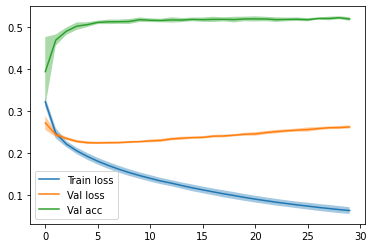

In [9]:
train_losses = []
val_losses = []
val_accs = []

for i in range(N_MODELS):
    train_losses.append(np.load(models_path / f'train_loss_{i}.npy'))
    val_losses.append(np.load(models_path / f'val_loss_{i}.npy'))
    val_accs.append(np.load(models_path / f'val_acc_{i}.npy'))

mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)

mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

mean_val_acc = np.mean(val_accs, axis=0)
std_val_acc = np.std(val_accs, axis=0)

plt.plot(list(range(N_EPOCHS)), mean_train_loss, label='Train loss')
plt.fill_between(list(range(N_EPOCHS)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.4)
plt.plot(list(range(N_EPOCHS)), mean_val_loss, label='Val loss')
plt.fill_between(list(range(N_EPOCHS)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.4)
plt.plot(list(range(N_EPOCHS)), mean_val_acc, label='Val acc')
plt.fill_between(list(range(N_EPOCHS)), mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.4)

plt.legend()
plt.show()

In [10]:
raise ValueError

ValueError: 

## Eval

In [ ]:
import pickle

entities = np.load('data/candidate_entities_sq_test.npy', allow_pickle=True)

with open('data/entity_subgraphs_sq_test.pickle', 'rb') as handle:
    entity_subgraphs = pickle.load(handle)

In [ ]:
sq_candidates = []

for question_entities in entities:
    candidates_dict = {}
    for entity in list(question_entities.item()):
        candidates_dict[entity] = entity_subgraphs[entity]
    sq_candidates.append(candidates_dict)

In [ ]:
simple_questions_test = np.load("../new_data/simple_questions_test.npy")

simple_questions_filtered = []
questions_sq = []
answers_sq = []

for e, p, a, q in tqdm(simple_questions_test):
    if e in graph_embeddings_Q and a in graph_embeddings_Q and p in graph_embeddings_P:
        simple_questions_filtered.append((e, p, a, q))
        questions_sq.append(q)
        answers_sq.append([a])

### RuBQ

#### Best acc models

In [ ]:
%autoreload

N_MODELS=5
proj_hidden_size = 512

models = []
for i in range(N_MODELS):
    encoder = EncoderBERT(device)
    projection_E = get_projection_module_simple(device, proj_hidden_size)
    projection_Q = get_projection_module_simple(device, proj_hidden_size)
    projection_P = get_projection_module_simple(device, proj_hidden_size)

    encoder.load_state_dict(torch.load(models_path / f'encoder_{i}_best_acc.pt'))
    projection_E.load_state_dict(torch.load(models_path / f'projection_E_{i}_best_acc.pt'))
    projection_Q.load_state_dict(torch.load(models_path / f'projection_Q_{i}_best_acc.pt'))
    projection_P.load_state_dict(torch.load(models_path / f'projection_P_{i}_best_acc.pt'))
    models.append({'encoder': encoder, 'projection_P': projection_P, 'projection_Q': projection_Q, 'projection_E': projection_E})
    
_, _, a_predicts, _, _, _, _, _, _, _, _, _, _, _, _, val_acc, _, _, _, _, _, a_model_predicts = eval_ensemble(questions_val, answers_val, graph_embeddings_P, graph_embeddings_Q, val_cands, models, device)

models_corrects = [[], [], [], [], []]

for i, (answers, models_preds, ensemble_preds) in enumerate(zip(answers_val, a_model_predicts, a_predicts)):
    corr_models = 0
    for j, model_preds in enumerate(models_preds):
        if model_preds[0] in answers:
            models_corrects[j].append(1.0)
            corr_models += 1
        else:
            models_corrects[j].append(0.0)
    
    if corr_models > 2 and (ensemble_preds[0] not in answers):
        print(i)
    
val_model_accs = [np.mean(model_corrects) for model_corrects in models_corrects]
weights = val_model_accs

In [ ]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, ensembling_mode='average', weights=weights)

#### Ind model accuracy

In [ ]:
models_corrects = [[], [], [], [], []]

for i, (answers, models_preds, ensemble_preds) in enumerate(zip(answers_test, a_model_predicts, a_predicts)):
    corr_models = 0
    if len(models_preds) == 0:
        for model_corrects in models_corrects:
            model_corrects.append(0.0)
    for j, model_preds in enumerate(models_preds):
        if model_preds[0] in answers:
            models_corrects[j].append(1.0)
            corr_models += 1
        else:
            models_corrects[j].append(0.0)
    
rubq_model_accs = [np.mean(model_corrects) for model_corrects in models_corrects]
mean_acc = np.mean(rubq_model_accs)
std_acc = np.std(rubq_model_accs)

print(rubq_model_accs)
print(round(max(rubq_model_accs), 3))
print(round(min(rubq_model_accs), 3))
print(round(mean_acc, 3))
print(round(std_acc, 3))

### SQ

In [ ]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, ensembling_mode='average', weights=weights)

#### Ind model accuracy

In [ ]:
models_corrects = [[], [], [], [], []]

for i, (answers, models_preds, ensemble_preds) in enumerate(zip(answers_sq, a_model_predicts, a_predicts)):
    if len(models_preds) == 0:
        for model_corrects in models_corrects:
            model_corrects.append(0.0)
            
    for j, model_preds in enumerate(models_preds):
        if model_preds[0] in answers:
            models_corrects[j].append(1.0)
            corr_models += 1
        else:
            models_corrects[j].append(0.0)
    
sq_model_accs = [np.mean(model_corrects) for model_corrects in models_corrects]
mean_acc = np.mean(sq_model_accs)
std_acc = np.std(sq_model_accs)

print(sq_model_accs)
print(round(max(sq_model_accs), 3))
print(round(min(sq_model_accs), 3))
print(round(mean_acc, 3))
print(round(std_acc, 3))

#### Epoch 30

In [ ]:
%autoreload

N_MODELS=5
proj_hidden_size = 512

models = []
for i in range(N_MODELS):
    encoder = EncoderBERT(device)
    projection_E = get_projection_module_simple(device, proj_hidden_size)
    projection_Q = get_projection_module_simple(device, proj_hidden_size)
    projection_P = get_projection_module_simple(device, proj_hidden_size)

    encoder.load_state_dict(torch.load(models_path / f'encoder_{i}_30.pt'))
    projection_E.load_state_dict(torch.load(models_path / f'projection_E_{i}_30.pt'))
    projection_Q.load_state_dict(torch.load(models_path / f'projection_Q_{i}_30.pt'))
    projection_P.load_state_dict(torch.load(models_path / f'projection_P_{i}_30.pt'))
    models.append({'encoder': encoder, 'projection_P': projection_P, 'projection_Q': projection_Q, 'projection_E': projection_E})
    
_, _, a_predicts, _, _, _, _, _, _, _, _, _, _, _, _, val_acc, _, _, _, _, _, a_model_predicts = eval_ensemble(questions_val, answers_val, graph_embeddings_P, graph_embeddings_Q, val_cands, models, device)

models_corrects = [[], [], [], [], []]

for i, (answers, models_preds, ensemble_preds) in enumerate(zip(answers_val, a_model_predicts, a_predicts)):
    corr_models = 0
    for j, model_preds in enumerate(models_preds):
        if model_preds[0] in answers:
            models_corrects[j].append(1.0)
            corr_models += 1
        else:
            models_corrects[j].append(0.0)
    
    if corr_models > 2 and (ensemble_preds[0] not in answers):
        print(i)
    
val_model_accs = [np.mean(model_corrects) for model_corrects in models_corrects]
weights = val_model_accs

In [ ]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_test, answers_test, graph_embeddings_P, graph_embeddings_Q, candidates, models, device, ensembling_mode='average', weights=weights)

#### Ind model accuracy

In [ ]:
models_corrects = [[], [], [], [], []]

for i, (answers, models_preds, ensemble_preds) in enumerate(zip(answers_test, a_model_predicts, a_predicts)):
    corr_models = 0
    if len(models_preds) == 0:
        for model_corrects in models_corrects:
            model_corrects.append(0.0)
    for j, model_preds in enumerate(models_preds):
        if model_preds[0] in answers:
            models_corrects[j].append(1.0)
            corr_models += 1
        else:
            models_corrects[j].append(0.0)
    
rubq_model_accs = [np.mean(model_corrects) for model_corrects in models_corrects]
mean_acc = np.mean(rubq_model_accs)
std_acc = np.std(rubq_model_accs)

print(rubq_model_accs)
print(round(max(rubq_model_accs), 3))
print(round(min(rubq_model_accs), 3))
print(round(mean_acc, 3))
print(round(std_acc, 3))

### SQ

In [ ]:
%autoreload

q_list, a_list, a_predicts, inv_ranks, top1_scores, top2_scores, e_stds, q_stds, p_stds, e_stds_norm, q_stds_norm, p_stds_norm, cosines_stds, entropies_of_mean, mean_entropies, acc, cosines_P_stds, cosines_Q_stds, cosines_E_stds, bad_question_ids, all_cosines, a_model_predicts = eval_ensemble(questions_sq, answers_sq, graph_embeddings_P, graph_embeddings_Q, sq_candidates, models, device, ensembling_mode='average', weights=weights)

#### Ind model accuracy

In [ ]:
models_corrects = [[], [], [], [], []]

for i, (answers, models_preds, ensemble_preds) in enumerate(zip(answers_sq, a_model_predicts, a_predicts)):
    if len(models_preds) == 0:
        for model_corrects in models_corrects:
            model_corrects.append(0.0)
            
    for j, model_preds in enumerate(models_preds):
        if model_preds[0] in answers:
            models_corrects[j].append(1.0)
            corr_models += 1
        else:
            models_corrects[j].append(0.0)
    
sq_model_accs = [np.mean(model_corrects) for model_corrects in models_corrects]
mean_acc = np.mean(sq_model_accs)
std_acc = np.std(sq_model_accs)

print(sq_model_accs)
print(round(max(sq_model_accs), 3))
print(round(min(sq_model_accs), 3))
print(round(mean_acc, 3))
print(round(std_acc, 3))